In [1]:
import os
import glob
import gc
import numpy as np
import pandas as pd
import rasterio
from rasterio.features import rasterize
from rasterio.windows import Window
import geopandas as gpd
from shapely.geometry import box
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import albumentations as A
import warnings

warnings.filterwarnings('ignore')

# --- Force Cleanup Before Start ---
gc.collect()
torch.cuda.empty_cache()

# --- CONFIGURATION ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths
ORTHO_DIR = "../PB_training_dataSet_shp_file"
SHP_DIR = "../PB_training_dataSet_shp_file/shp-file"
OUTPUT_DIR = "../data/processed/water_512"  # Using 512 tiles

# Training Params (Optimized for 8GB GPU)
TILE_SIZE = 512     # Safe for 8GB VRAM
BATCH_SIZE = 4      # Works well with 512x512
EPOCHS = 25
LR = 1e-4

# Create Directories
os.makedirs(f"{OUTPUT_DIR}/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/masks", exist_ok=True)
os.makedirs("../models", exist_ok=True)

print(f"Device: {DEVICE}")
print(f"Tile Size: {TILE_SIZE}x{TILE_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")

Device: cuda
Tile Size: 512x512
Batch Size: 4


In [2]:
def prepare_water_dataset(ortho_dir, shp_dir, output_dir, tile_size=512):
    print("=== STEP 1: Loading & Merging Shapefiles ===")
    water_geoms = []
    
    # Polygons
    poly_path = os.path.join(shp_dir, "Water_Body.shp")
    if os.path.exists(poly_path):
        poly_gdf = gpd.read_file(poly_path)
        water_geoms.append(poly_gdf)
        print(f"  Loaded {len(poly_gdf)} Polygons")

    # Lines -> Buffer 1.5m
    line_path = os.path.join(shp_dir, "Water_Body_Line.shp")
    if os.path.exists(line_path):
        line_gdf = gpd.read_file(line_path)
        line_gdf['geometry'] = line_gdf.geometry.buffer(1.5)
        water_geoms.append(line_gdf)
        print(f"  Loaded {len(line_gdf)} Lines (buffered)")

    # Points -> Buffer 2.5m
    point_path = os.path.join(shp_dir, "Waterbody_Point.shp")
    if os.path.exists(point_path):
        point_gdf = gpd.read_file(point_path)
        point_gdf['geometry'] = point_gdf.geometry.buffer(2.5)
        water_geoms.append(point_gdf)
        print(f"  Loaded {len(point_gdf)} Points (buffered)")
    
    if not water_geoms:
        print("ERROR: No shapefiles found!")
        return
        
    master_gdf = gpd.GeoDataFrame(pd.concat(water_geoms, ignore_index=True))
    
    print("\n=== STEP 2 & 3: Tiling & Rasterization ===")
    ortho_files = glob.glob(os.path.join(ortho_dir, "*.tif"))
    saved_count = 0
    
    for ortho_path in ortho_files:
        filename = os.path.basename(ortho_path).replace('.tif', '')
        print(f"Processing: {filename}")
        
        with rasterio.open(ortho_path) as src:
            gdf_proj = master_gdf.to_crs(src.crs) if master_gdf.crs != src.crs else master_gdf
            sindex = gdf_proj.sindex
            h, w = src.height, src.width
            
            for y in range(0, h, tile_size):
                for x in range(0, w, tile_size):
                    window = Window(x, y, tile_size, tile_size)
                    win_transform = src.window_transform(window)
                    win_bounds = rasterio.windows.bounds(window, transform=src.transform)
                    win_box = box(*win_bounds)
                    
                    possible = list(sindex.intersection(win_box.bounds))
                    matches = gdf_proj.iloc[possible]
                    matches = matches[matches.intersects(win_box)]
                    
                    img = src.read(window=window)
                    c, h_win, w_win = img.shape
                    
                    if h_win < tile_size or w_win < tile_size:
                        img = np.pad(img, ((0,0), (0, tile_size-h_win), (0, tile_size-w_win)), mode='constant')
                        h_win, w_win = tile_size, tile_size
                    
                    if not matches.empty:
                        mask = rasterize(matches.geometry, out_shape=(h_win, w_win),
                                         transform=win_transform, default_value=1, fill=0, dtype='uint8')
                    else:
                        mask = np.zeros((h_win, w_win), dtype='uint8')
                    
                    # Filter: Keep if >1% water OR 5% chance for background
                    water_ratio = np.sum(mask) / (tile_size * tile_size)
                    if water_ratio >= 0.01 or np.random.rand() < 0.05:
                        img_save = cv2.cvtColor(np.moveaxis(img, 0, -1), cv2.COLOR_RGB2BGR)
                        save_name = f"{filename}_{x}_{y}.png"
                        cv2.imwrite(f"{output_dir}/images/{save_name}", img_save)
                        cv2.imwrite(f"{output_dir}/masks/{save_name}", mask * 255)
                        saved_count += 1
                        
    print(f"\nDone! Saved {saved_count} tiles.")

# Run if needed
if len(glob.glob(f"{OUTPUT_DIR}/images/*.png")) < 10:
    prepare_water_dataset(ORTHO_DIR, SHP_DIR, OUTPUT_DIR, TILE_SIZE)
else:
    print(f"Data already exists: {len(glob.glob(f'{OUTPUT_DIR}/images/*.png'))} tiles found.")

Data already exists: 2259 tiles found.


In [3]:
def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    pred = (pred_mask > threshold).float().view(-1)
    true = true_mask.view(-1)
    
    TP = (pred * true).sum().item()
    FP = (pred * (1 - true)).sum().item()
    FN = ((1 - pred) * true).sum().item()
    TN = ((1 - pred) * (1 - true)).sum().item()
    
    accuracy = (TP + TN) / (TP + FP + FN + TN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    return accuracy, iou, f1

class WaterDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform
        
    def __len__(self): 
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.float32)
        
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
            
        img = img.transpose(2,0,1).astype(np.float32) / 255.0
        mask = np.expand_dims(mask, 0)
        return torch.from_numpy(img), torch.from_numpy(mask)

def get_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
    ])

ds = WaterDataset(f"{OUTPUT_DIR}/images", f"{OUTPUT_DIR}/masks", get_transforms())
train_loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print(f"Training Samples: {len(ds)}")

Training Samples: 2259


In [4]:
# --- Clean GPU Memory ---
gc.collect()
torch.cuda.empty_cache()

# --- Model ---
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)
model.to(DEVICE)

# --- Loss: Dice + BCE ---
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

def combo_loss(pred, target):
    return 0.5 * criterion_bce(pred, target) + 0.5 * criterion_dice(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- Training ---
history = {'loss': [], 'iou': [], 'acc': [], 'f1': []}
best_iou = 0.0

print(f"Training for {EPOCHS} epochs on {len(ds)} samples...")

for epoch in range(EPOCHS):
    model.train()
    stats = {'loss': 0, 'acc': 0, 'iou': 0, 'f1': 0}
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for imgs, masks in loop:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combo_loss(logits, masks)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            probs = torch.sigmoid(logits)
            acc, iou, f1 = calculate_metrics(probs, masks)
        
        stats['loss'] += loss.item()
        stats['acc'] += acc
        stats['iou'] += iou
        stats['f1'] += f1
        
        loop.set_postfix(loss=f"{loss.item():.4f}", iou=f"{iou:.4f}")
    
    n = len(train_loader)
    avg = {k: v/n for k, v in stats.items()}
    
    for k in history:
        history[k].append(avg[k])
    
    print(f"Epoch {epoch+1:02d} | Loss: {avg['loss']:.4f} | IoU: {avg['iou']:.4f} | Acc: {avg['acc']:.4f} | F1: {avg['f1']:.4f}")
    
    if avg['iou'] > best_iou:
        best_iou = avg['iou']
        torch.save(model.state_dict(), "../models/water_unet_best.pth")
        print(f"  ✓ Best model saved (IoU: {best_iou:.4f})")

torch.save(model.state_dict(), "../models/water_unet_final.pth")
print("\n=== Training Complete ===")
print(f"Best IoU: {best_iou:.4f}")

Training for 25 epochs on 2259 samples...


Epoch 01 | Loss: 0.4992 | IoU: 0.2327 | Acc: 0.8298 | F1: 0.3242
  ✓ Best model saved (IoU: 0.2327)


Epoch 02 | Loss: 0.4091 | IoU: 0.2947 | Acc: 0.8875 | F1: 0.3982
  ✓ Best model saved (IoU: 0.2947)


Epoch 03 | Loss: 0.3767 | IoU: 0.3321 | Acc: 0.8996 | F1: 0.4358
  ✓ Best model saved (IoU: 0.3321)


Epoch 04 | Loss: 0.3523 | IoU: 0.3510 | Acc: 0.9078 | F1: 0.4513
  ✓ Best model saved (IoU: 0.3510)


Epoch 05 | Loss: 0.3399 | IoU: 0.3701 | Acc: 0.9192 | F1: 0.4737
  ✓ Best model saved (IoU: 0.3701)


Epoch 06 | Loss: 0.3115 | IoU: 0.4087 | Acc: 0.9246 | F1: 0.5092
  ✓ Best model saved (IoU: 0.4087)


Epoch 07 | Loss: 0.2900 | IoU: 0.4088 | Acc: 0.9330 | F1: 0.5086
  ✓ Best model saved (IoU: 0.4088)


Epoch 08 | Loss: 0.2922 | IoU: 0.4196 | Acc: 0.9305 | F1: 0.5211
  ✓ Best model saved (IoU: 0.4196)


Epoch 09 | Loss: 0.2759 | IoU: 0.4304 | Acc: 0.9371 | F1: 0.5305
  ✓ Best model saved (IoU: 0.4304)


Epoch 10 | Loss: 0.2572 | IoU: 0.4446 | Acc: 0.9397 | F1: 0.5416
  ✓ Best model saved (IoU: 0.4446)


Epoch 11 | Loss: 0.2658 | IoU: 0.4445 | Acc: 0.9402 | F1: 0.5423


Epoch 12 | Loss: 0.2534 | IoU: 0.4683 | Acc: 0.9447 | F1: 0.5679
  ✓ Best model saved (IoU: 0.4683)


Epoch 13 | Loss: 0.2370 | IoU: 0.4776 | Acc: 0.9465 | F1: 0.5726
  ✓ Best model saved (IoU: 0.4776)


Epoch 14 | Loss: 0.2619 | IoU: 0.4713 | Acc: 0.9432 | F1: 0.5700


Epoch 15 | Loss: 0.2252 | IoU: 0.5024 | Acc: 0.9514 | F1: 0.5984
  ✓ Best model saved (IoU: 0.5024)


Epoch 16 | Loss: 0.2312 | IoU: 0.4964 | Acc: 0.9518 | F1: 0.5914


Epoch 17 | Loss: 0.2254 | IoU: 0.4964 | Acc: 0.9487 | F1: 0.5895


Epoch 18 | Loss: 0.2285 | IoU: 0.5133 | Acc: 0.9510 | F1: 0.6076
  ✓ Best model saved (IoU: 0.5133)


Epoch 19 | Loss: 0.2238 | IoU: 0.5148 | Acc: 0.9540 | F1: 0.6079
  ✓ Best model saved (IoU: 0.5148)


Epoch 20 | Loss: 0.2193 | IoU: 0.5074 | Acc: 0.9531 | F1: 0.6016


Epoch 21 | Loss: 0.2094 | IoU: 0.5250 | Acc: 0.9569 | F1: 0.6174
  ✓ Best model saved (IoU: 0.5250)


Epoch 22 | Loss: 0.2076 | IoU: 0.5106 | Acc: 0.9580 | F1: 0.6010


Epoch 23 | Loss: 0.2147 | IoU: 0.5043 | Acc: 0.9532 | F1: 0.5972


Epoch 24 | Loss: 0.1996 | IoU: 0.5342 | Acc: 0.9588 | F1: 0.6257
  ✓ Best model saved (IoU: 0.5342)


Epoch 25 | Loss: 0.2080 | IoU: 0.5358 | Acc: 0.9547 | F1: 0.6248
  ✓ Best model saved (IoU: 0.5358)

=== Training Complete ===
Best IoU: 0.5358


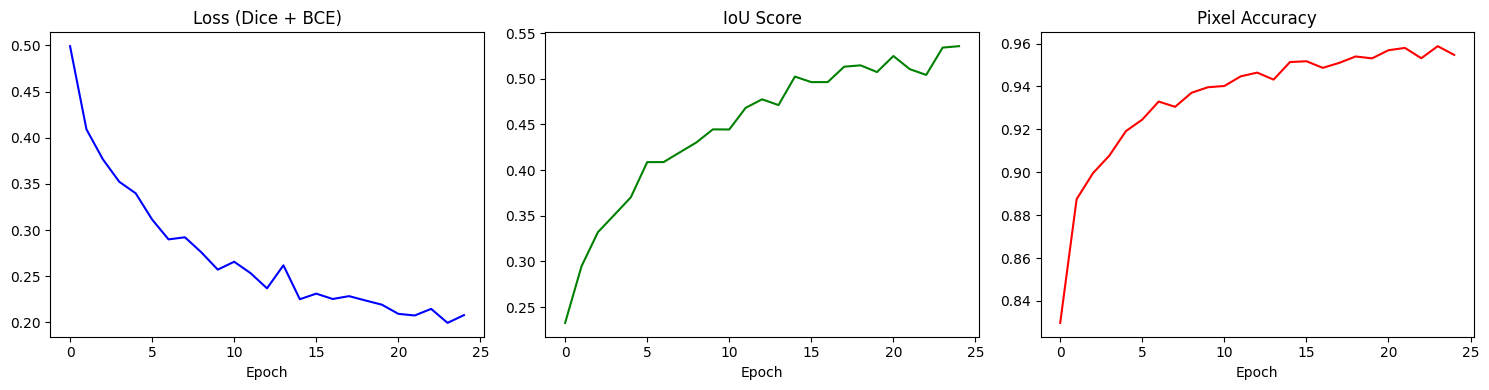

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'], 'b-')
axes[0].set_title("Loss (Dice + BCE)")
axes[0].set_xlabel("Epoch")

axes[1].plot(history['iou'], 'g-')
axes[1].set_title("IoU Score")
axes[1].set_xlabel("Epoch")

axes[2].plot(history['acc'], 'r-')
axes[2].set_title("Pixel Accuracy")
axes[2].set_xlabel("Epoch")

plt.tight_layout()
plt.savefig("../outputs/water_training_curves.png")
plt.show()

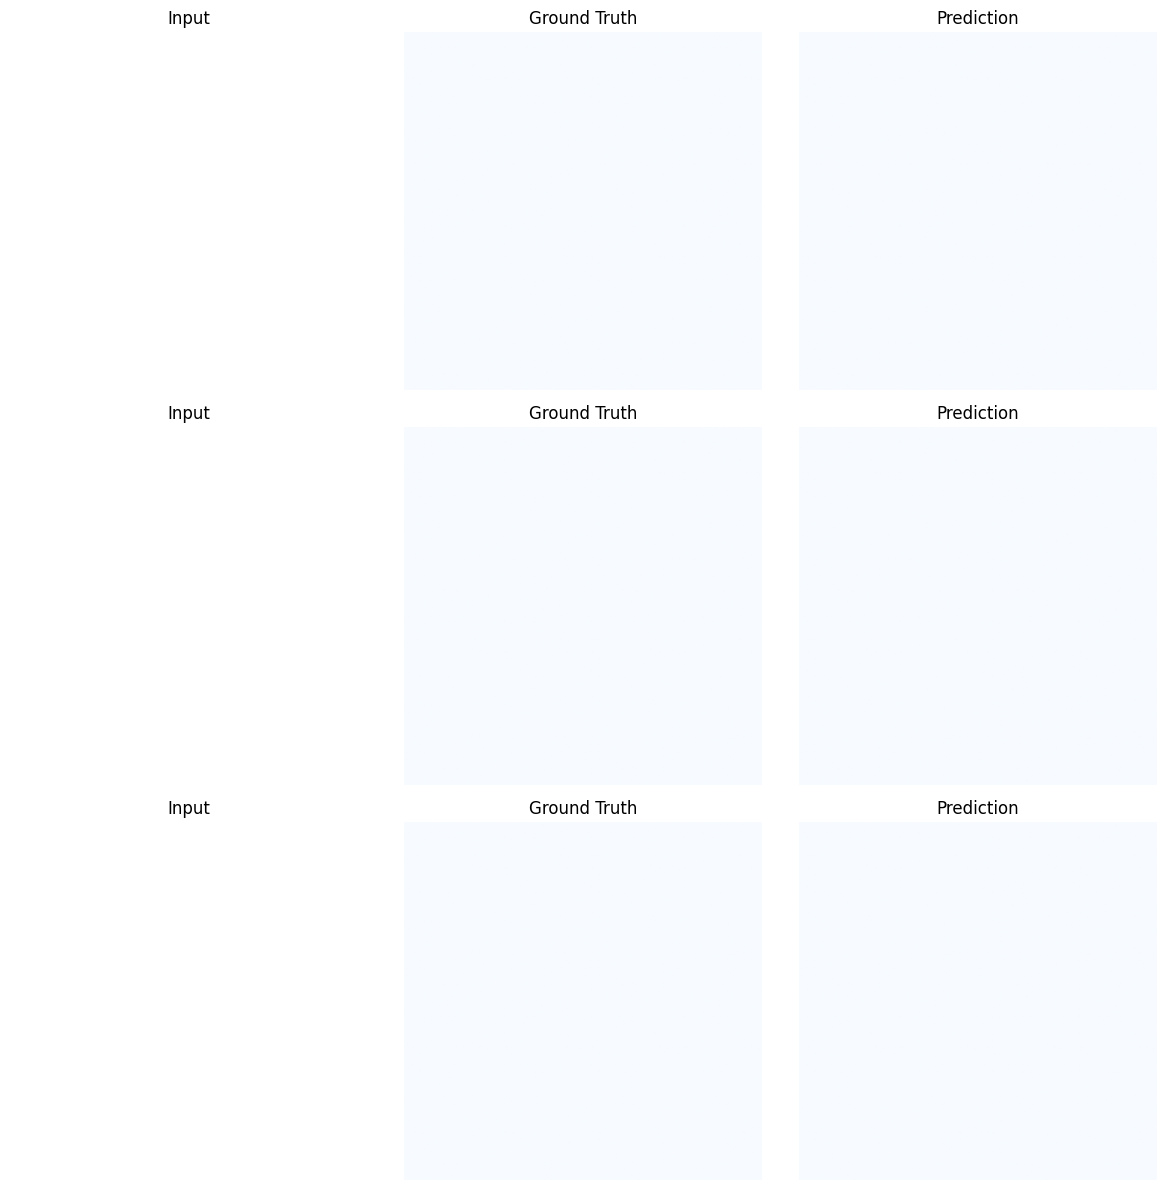

In [6]:
def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i, idx in enumerate(indices):
        img_path = dataset.img_paths[idx]
        mask_path = dataset.mask_paths[idx]
        
        img_vis = cv2.imread(img_path)
        img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
        mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        img_t, _ = dataset[idx]
        img_t = img_t.unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            logits = model(img_t)
            pred = (torch.sigmoid(logits) > 0.5).cpu().numpy()[0, 0]
        
        # Post-process
        kernel = np.ones((3,3), np.uint8)
        pred_clean = cv2.morphologyEx(pred.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        
        axes[i, 0].imshow(img_vis)
        axes[i, 0].set_title("Input")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_gt, cmap='Blues')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_clean, cmap='Blues')
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig("../outputs/water_predictions.png")
    plt.show()

visualize_predictions(model, ds, num_samples=3)

Device: cuda
Tile Size: 256x256
Model loaded!
Image: 28119 x 26576


Inference: 100%|██████████| 11440/11440 [01:34<00:00, 121.26it/s]



Mask saved: ../outputs/water_mask_anaitpura.tif
Post-processing...
Water pixels: 3,152,838
Creating visualization...


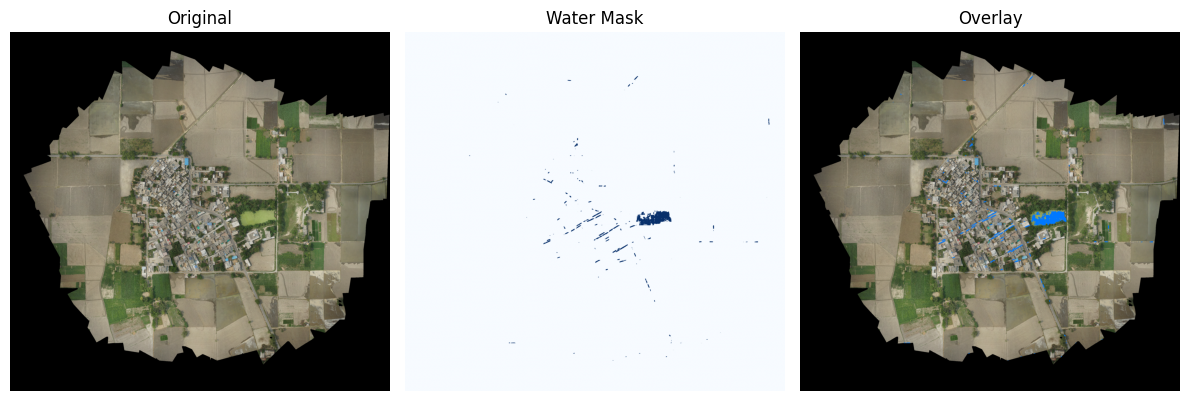


=== Done! ===


In [3]:
import os
import gc
import numpy as np
import rasterio
from rasterio.windows import Window
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# --- AGGRESSIVE CLEANUP ---
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

# --- Configuration ---
MODEL_PATH = "../models/water_unet_best.pth"
TEST_IMAGE = "data/live_demo_2/ANAITPURA_FATEHGARH_SAHIB_32705_ORTHO/ANAITPURA_FATEHGARH SAHIB_32705_ORTHO.tif"
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TILE_SIZE = 256  # Smaller tiles = less memory
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device: {DEVICE}")
print(f"Tile Size: {TILE_SIZE}x{TILE_SIZE}")

# --- Load Model ---
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print("Model loaded!")

# --- Ultra-Safe Inference ---
with rasterio.open(TEST_IMAGE) as src:
    img_h, img_w = src.height, src.width
    profile = src.profile.copy()
    print(f"Image: {img_w} x {img_h}")

# Create output mask on disk (memory mapped)
mask_path = os.path.join(OUTPUT_DIR, "water_mask_anaitpura.tif")
profile.update(dtype='uint8', count=1)

with rasterio.open(mask_path, 'w', **profile) as dst:
    with rasterio.open(TEST_IMAGE) as src:
        
        total = ((img_h + TILE_SIZE - 1) // TILE_SIZE) * ((img_w + TILE_SIZE - 1) // TILE_SIZE)
        pbar = tqdm(total=total, desc="Inference")
        
        with torch.no_grad():
            for y in range(0, img_h, TILE_SIZE):
                for x in range(0, img_w, TILE_SIZE):
                    # Window size
                    win_h = min(TILE_SIZE, img_h - y)
                    win_w = min(TILE_SIZE, img_w - x)
                    window = Window(x, y, win_w, win_h)
                    
                    # Read RGB only
                    tile = src.read([1, 2, 3], window=window)
                    
                    # Pad
                    if win_h < TILE_SIZE or win_w < TILE_SIZE:
                        tile = np.pad(tile, ((0,0), (0, TILE_SIZE-win_h), (0, TILE_SIZE-win_w)), mode='reflect')
                    
                    # Predict
                    t = torch.from_numpy(tile).float().unsqueeze(0) / 255.0
                    t = t.to(DEVICE)
                    pred = torch.sigmoid(model(t)).cpu().numpy()[0, 0]
                    
                    # Threshold
                    mask_tile = (pred[:win_h, :win_w] > 0.5).astype(np.uint8)
                    
                    # Write directly to disk
                    dst.write(mask_tile, 1, window=window)
                    
                    # Cleanup
                    del tile, t, pred, mask_tile
                    pbar.update(1)
                
                # Clear GPU after each row
                torch.cuda.empty_cache()
                gc.collect()
        
        pbar.close()

print(f"\nMask saved: {mask_path}")

# --- Post-process the saved mask ---
print("Post-processing...")
with rasterio.open(mask_path) as src:
    mask = src.read(1)
    profile = src.profile

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Remove noise
n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_clean)
for i in range(1, n_labels):
    if stats[i, cv2.CC_STAT_AREA] < 50:
        mask_clean[labels == i] = 0

del labels, stats
gc.collect()

# Overwrite with cleaned mask
with rasterio.open(mask_path, 'w', **profile) as dst:
    dst.write(mask_clean, 1)

print(f"Water pixels: {np.sum(mask_clean):,}")

# --- Simple Visualization (downsampled) ---
print("Creating visualization...")
step = 10

with rasterio.open(TEST_IMAGE) as src:
    rgb = src.read([1, 2, 3], out_shape=(3, src.height // step, src.width // step))

rgb_viz = np.moveaxis(rgb, 0, -1)

# Resize mask to match RGB exactly
mask_viz = cv2.resize(mask_clean, (rgb_viz.shape[1], rgb_viz.shape[0]), interpolation=cv2.INTER_NEAREST)

del mask, mask_clean
gc.collect()

# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(rgb_viz)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(mask_viz, cmap='Blues')
ax[1].set_title("Water Mask")
ax[1].axis('off')

overlay = rgb_viz.copy()
overlay[mask_viz == 1] = [0, 120, 255]
ax[2].imshow(overlay)
ax[2].set_title("Overlay")
ax[2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "water_result.png"), dpi=100)
plt.show()

print("\n=== Done! ===")